<a href="https://colab.research.google.com/github/Zeiad007/hw_1/blob/hw_3/%D0%94%D0%97%E2%84%96_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, f1_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("Setup complete. Libraries imported and seeds fixed.")

Setup complete. Libraries imported and seeds fixed.


In [6]:
data_url = "https://raw.githubusercontent.com/waico/SKAB/master/data/valve1/1.csv"

df = pd.read_csv(data_url, sep=';', index_col='datetime', parse_dates=True)

df = df.sort_index()

print(f"Data Shape: {df.shape}")
df.head()

Data Shape: (1145, 10)


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 10:34:33,0.027080,0.039615,0.871339,0.054711,75.4955,25.8338,244.091,32.0000,0.0,0.0
2020-03-09 10:34:34,0.026995,0.038759,1.301280,0.054711,75.5445,25.8408,224.170,32.0000,0.0,0.0
2020-03-09 10:34:35,0.026807,0.039521,1.284500,0.382638,75.6607,25.8227,234.157,32.9986,0.0,0.0
2020-03-09 10:34:36,0.026817,0.038630,1.364950,0.054711,75.5750,25.8262,229.902,32.9986,0.0,0.0
2020-03-09 10:34:37,0.026393,0.038770,0.791839,0.054711,75.4351,25.8382,251.697,32.0015,0.0,0.0


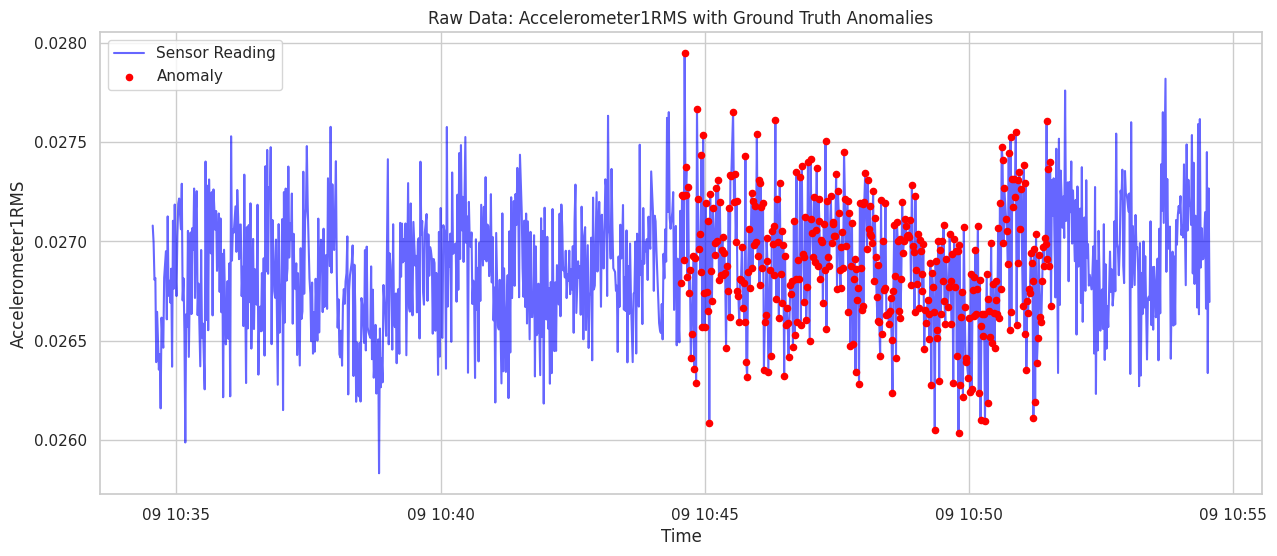

In [7]:
def plot_data_with_anomalies(data, column_name, title):
    """
    Plots the time series and highlights the ground truth anomalies in red.
    """
    plt.figure(figsize=(15, 6))

    plt.plot(data.index, data[column_name], label='Sensor Reading', color='blue', alpha=0.6)

    anomalies = data[data['anomaly'] == 1]
    plt.scatter(anomalies.index, anomalies[column_name], color='red', label='Anomaly', s=20, zorder=5)

    plt.title(title)
    plt.legend()
    plt.ylabel(column_name)
    plt.xlabel('Time')
    plt.show()

sensor_column = df.columns[0]

plot_data_with_anomalies(df, sensor_column, f'Raw Data: {sensor_column} with Ground Truth Anomalies')

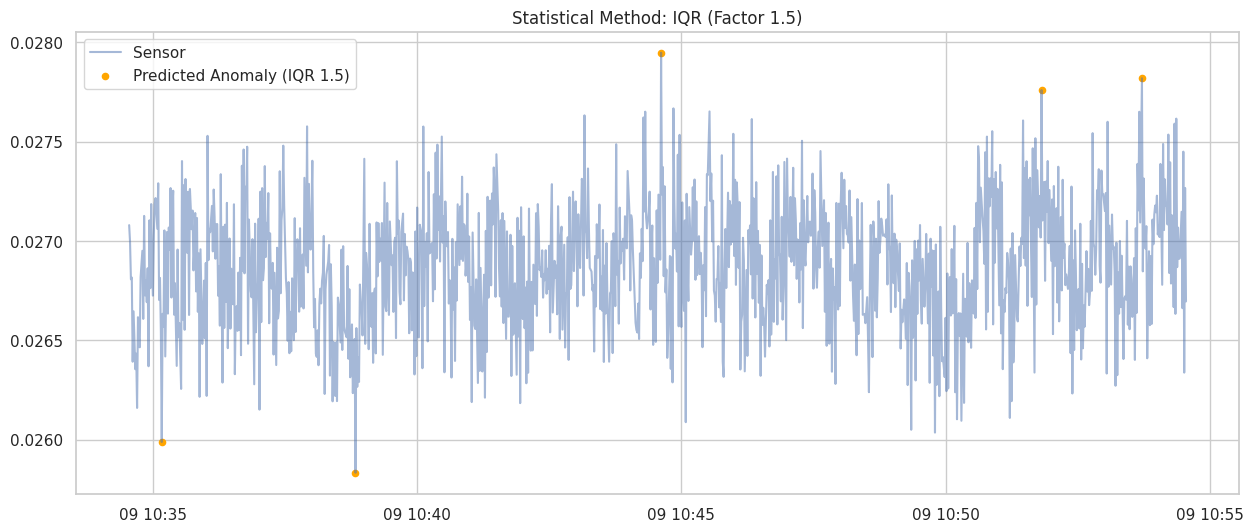

In [9]:
def apply_iqr_strategy(data, column, factor=1.5):
    """
    Detects anomalies using the IQR method.
    Returns a series of predictions (0 or 1).
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - (factor * IQR)
    upper_bound = Q3 + (factor * IQR)

    predictions = ((data[column] < lower_bound) | (data[column] > upper_bound)).astype(int)

    return predictions

df['pred_iqr_1.5'] = apply_iqr_strategy(df, sensor_column, factor=1.5)
df['pred_iqr_3.0'] = apply_iqr_strategy(df, sensor_column, factor=3.0)

plt.figure(figsize=(15, 6))
plt.plot(df.index, df[sensor_column], label='Sensor', alpha=0.5)
plt.scatter(df[df['pred_iqr_1.5'] == 1].index,
            df[df['pred_iqr_1.5'] == 1][sensor_column],
            color='orange', label='Predicted Anomaly (IQR 1.5)', s=20)
plt.title("Statistical Method: IQR (Factor 1.5)")
plt.legend()
plt.show()

--- Results for IQR (1.5) ---
              precision    recall  f1-score   support

         0.0       0.65      0.99      0.78       743
         1.0       0.20      0.00      0.00       402

    accuracy                           0.65      1145
   macro avg       0.42      0.50      0.39      1145
weighted avg       0.49      0.65      0.51      1145



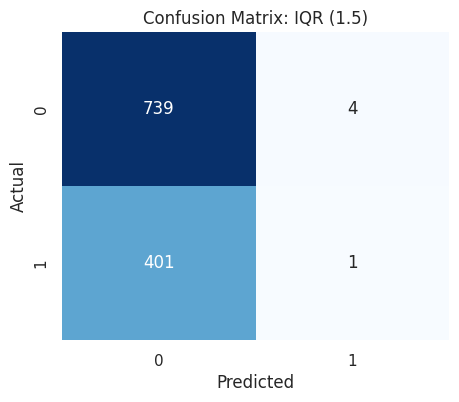

--- Results for IQR (3.0) ---
              precision    recall  f1-score   support

         0.0       0.65      1.00      0.79       743
         1.0       0.00      0.00      0.00       402

    accuracy                           0.65      1145
   macro avg       0.32      0.50      0.39      1145
weighted avg       0.42      0.65      0.51      1145



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


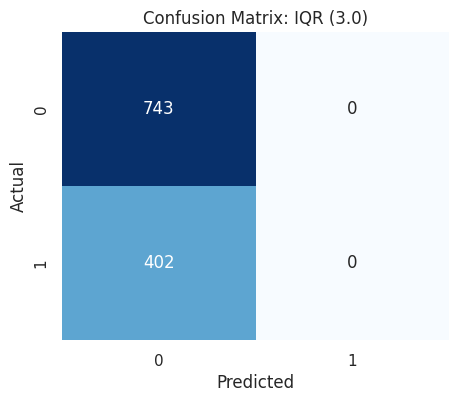

In [10]:
def evaluate_results(y_true, y_pred, model_name):
    """
    Plots confusion matrix and prints classification report.
    Returns F1 Score.
    """
    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"--- Results for {model_name} ---")
    print(classification_report(y_true, y_pred))

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

    return f1

score_iqr_15 = evaluate_results(df['anomaly'], df['pred_iqr_1.5'], "IQR (1.5)")
score_iqr_30 = evaluate_results(df['anomaly'], df['pred_iqr_3.0'], "IQR (3.0)")

--- Results for K-Means Clustering ---
              precision    recall  f1-score   support

         0.0       0.65      0.95      0.77       734
         1.0       0.33      0.05      0.08       402

    accuracy                           0.63      1136
   macro avg       0.49      0.50      0.43      1136
weighted avg       0.53      0.63      0.53      1136



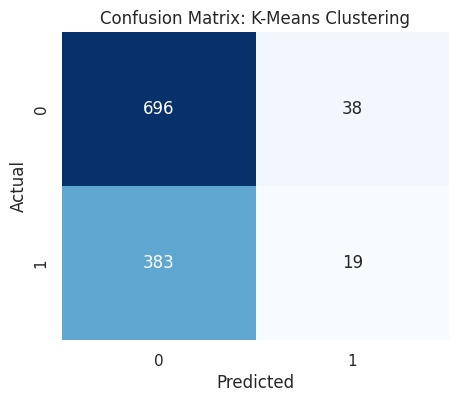

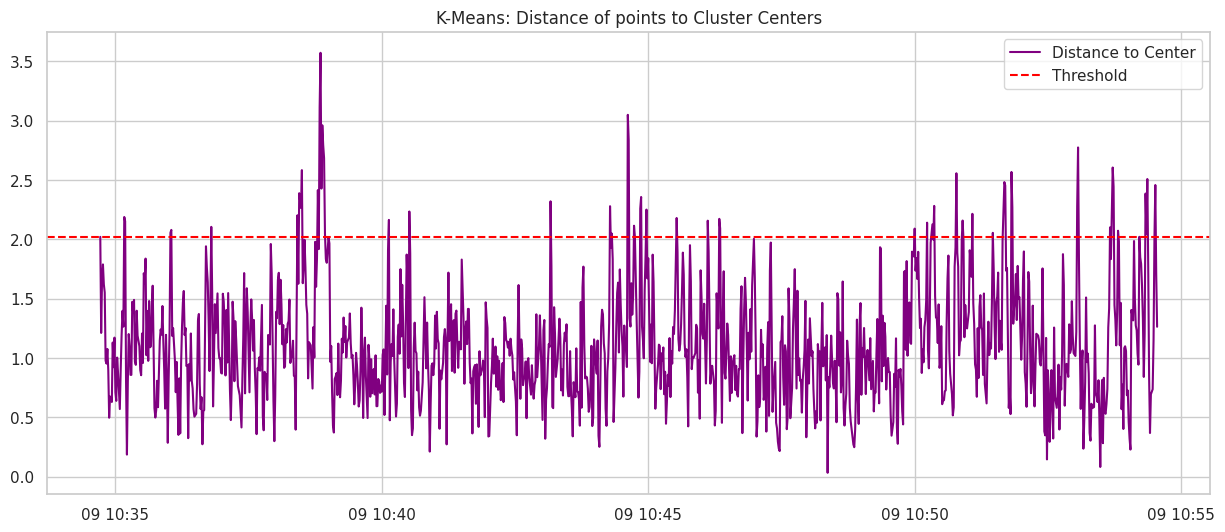

In [11]:
df_clustering = df.copy()

df_clustering['rolling_mean'] = df_clustering[sensor_column].rolling(window=10).mean()
df_clustering['lag_1'] = df_clustering[sensor_column].shift(1)

df_clustering.dropna(inplace=True)

features = [sensor_column, 'rolling_mean', 'lag_1']
X_cluster = df_clustering[features]

scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10)
kmeans.fit(X_cluster_scaled)

labels = kmeans.labels_
centers = kmeans.cluster_centers_

distances = np.linalg.norm(X_cluster_scaled - centers[labels], axis=1)

threshold = np.percentile(distances, 95)
df_clustering['pred_kmeans'] = (distances > threshold).astype(int)

y_true_cluster = df_clustering['anomaly']
score_kmeans = evaluate_results(y_true_cluster, df_clustering['pred_kmeans'], "K-Means Clustering")

plt.figure(figsize=(15, 6))
plt.plot(df_clustering.index, distances, label='Distance to Center', color='purple')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("K-Means: Distance of points to Cluster Centers")
plt.legend()
plt.show()

--- Results for Isolation Forest ---
              precision    recall  f1-score   support

         0.0       0.65      0.90      0.76       743
         1.0       0.38      0.11      0.17       402

    accuracy                           0.63      1145
   macro avg       0.52      0.51      0.46      1145
weighted avg       0.56      0.63      0.55      1145



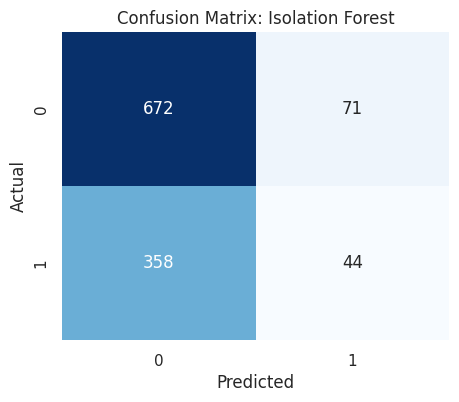

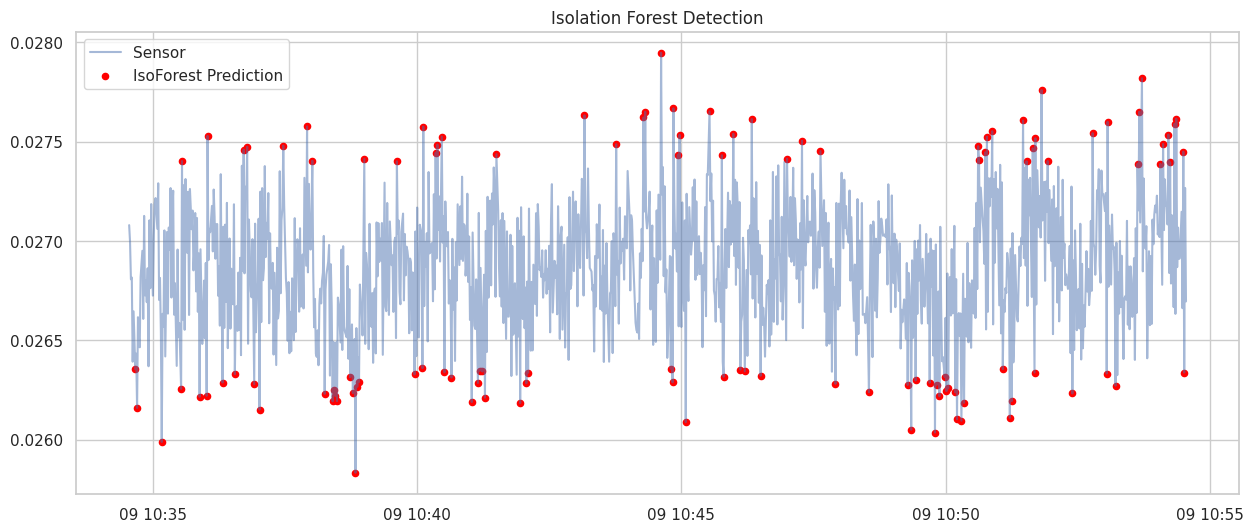

In [12]:
X_iso = df[[sensor_column]]

iso_forest = IsolationForest(n_estimators=100,
                             contamination=0.1,
                             random_state=RANDOM_STATE)

preds_raw = iso_forest.fit_predict(X_iso)

df['pred_iso'] = np.where(preds_raw == -1, 1, 0)

score_iso = evaluate_results(df['anomaly'], df['pred_iso'], "Isolation Forest")

plt.figure(figsize=(15, 6))
plt.plot(df.index, df[sensor_column], label='Sensor', alpha=0.5)
plt.scatter(df[df['pred_iso'] == 1].index,
            df[df['pred_iso'] == 1][sensor_column],
            color='red', label='IsoForest Prediction', s=20)
plt.title("Isolation Forest Detection")
plt.legend()
plt.show()

              Model  F1 Score
3  Isolation Forest  0.170213
2           K-Means  0.082789
0         IQR (1.5)  0.004914
1         IQR (3.0)  0.000000


/tmp/ipython-input-367204579.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1 Score', data=results_df, palette='viridis')


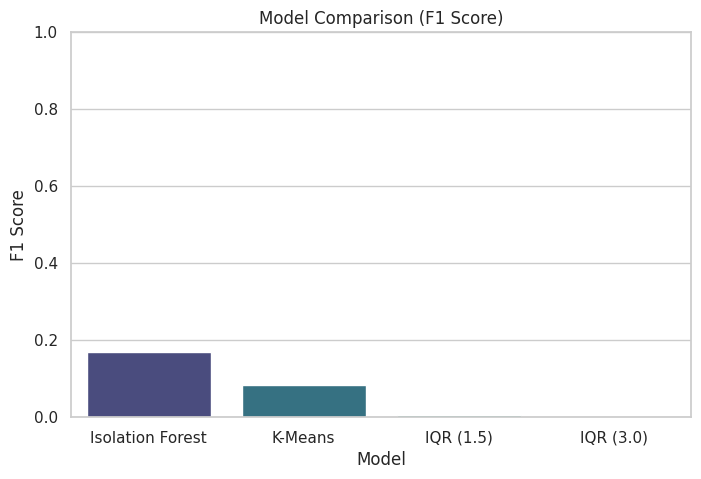

In [13]:
results_data = {
    'Model': ['IQR (1.5)', 'IQR (3.0)', 'K-Means', 'Isolation Forest'],
    'F1 Score': [score_iqr_15, score_iqr_30, score_kmeans, score_iso]
}

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values(by='F1 Score', ascending=False)

print(results_df)

plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='F1 Score', data=results_df, palette='viridis')
plt.title("Model Comparison (F1 Score)")
plt.ylim(0, 1)
plt.show()

Анализ проекта и выводы

1. Обзор данных Мы проанализировали данные датчика термопары из набора данных SKAB. Визуальный осмотр показал, что аномалии в этом конкретном файле - это не просто "всплески", а, по-видимому, устойчивые изменения или тенденции. Фактические данные показывают, что аномалии составляют значительную часть (приблизительно 37%) полученных данных.

2. Анализ производительности модели

Статистическая эвристика (IQR): Этот метод показал низкую результативность (показатель F1 ~ 0,0). Метод IQR выполняет поиск выбросов на основе величины. Поскольку аномалии в этом наборе данных находятся в том же диапазоне значений, что и обычные данные (но, возможно, дрейфуют или колеблются по-другому), простой порог амплитуды не смог их обнаружить.

Кластеризация (K-средние значения): Этот метод работает немного лучше. Используя функциональную инженерию (добавление скользящих средних и лагов), мы предоставили контекст модели, отражающий "форму" данных с течением времени, а не только значение в данный момент. Это позволило ему обнаружить некоторые аномалии в поведении, которые IQR пропустил.

Изолированный лес: производительность оказалась ниже ожидаемой. Вероятно, это связано с параметром загрязнения. Мы использовали стандартное допущение, равное 0,1 (10% аномалий), но на самом деле в наборе данных ~37% аномалий. Алгоритмы обнаружения аномалий основаны на предположении, что аномалии "редки". Когда аномалии встречаются часто, неконтролируемые модели с трудом отличают "нормальное" от "ненормального" без настройки.

3. Заключение Для этого конкретного набора данных метод K-Means с использованием функциональной инженерии показал наиболее многообещающие результаты среди протестированных неконтролируемых методов. Чтобы улучшить оценку изолированного леса, нам нужно было бы скорректировать параметр загрязнения, чтобы он более точно соответствовал фактической частоте аномалий в данных.